investigate the trend in lake area from other sources

In [1]:
import os
import rasterio as rio
import numpy as np
import shapely 
import pyproj
import geopandas as gpd
import matplotlib.pyplot as plt
import rioxarray as riox
import rasterio as rio
import xarray as xr
import netCDF4
from osgeo import gdal
import pandas as pd
from datetime import datetime
import dask.array
import matplotlib as mpl

In [2]:
# define folder and file paths
folder_HMA = os.path.join('C:',os.sep,'Users','lzell','OneDrive - Colostate','Desktop',"HMA2")
folder_glaciers = os.path.join(folder_HMA, 'Glacier Products')
folder_datasets = os.path.join(folder_HMA, 'Datasets')
fp_rgi = os.path.join(folder_HMA, 'Datasets', 'AOI definition', 'Final AOI', "Final Products", 'AOI_full_rgi.shp')
fp_regions = os.path.join(folder_HMA, 'Datasets', 'AOI definition', 'Final AOI', "Final Products", 'subregion_boundaries.shp')
fp_dc = os.path.join(folder_HMA, 'Datasets', 'AOI definition', 'Final AOI', "Final Products", 'AOI_dc_rgi.shp')

In [3]:
# open the rgi gdf, regions gdf
rgi_gdf = gpd.read_file(fp_rgi).to_crs("ESRI:102025")
dc_gdf = gpd.read_file(fp_dc).to_crs("ESRI:102025")
regions_gdf = gpd.read_file(fp_regions).to_crs("ESRI:102025")

# add the o3region as a column to each rgi
regions_gdf = regions_gdf.rename({"id":"o3region"}, axis=1)
dc_gdf = dc_gdf.sjoin(regions_gdf[["o3region","geometry"]])
rgi_gdf = rgi_gdf.sjoin(regions_gdf[["o3region","geometry"]])

In [4]:
# load in the list of lake-terminating glaciers, so we can remove those if we want
path_open = os.path.join(folder_datasets, 'lake-terminating glaciers', 'rgi_lake_terminating.csv')
df_lake_term = pd.read_csv(path_open)
rgi_lake_term = df_lake_term['rgi_id'].values

In [5]:
# remove lake-terminating from our dataset
dc_gdf_nlt = dc_gdf[~dc_gdf['rgi_id'].isin(rgi_lake_term)]

In [6]:
# calculate total debris-covered area in our aois (m2)
total_dc_area = np.nansum( [ g.area for g in dc_gdf['geometry']] )
total_dc_area_nlt = np.nansum( [ g.area for g in dc_gdf_nlt['geometry']] )
print(total_dc_area/(1000*1000), total_dc_area_nlt/(1000*1000))

2513.789050508341 2470.512267351526


In [7]:
# matplotlib stuff
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['mathtext.fontset'] = 'custom'
mpl.rcParams['mathtext.rm'] = 'Arial'

### Chen et al 2021 Hi-MAG database

In [8]:
# open chen_2021 lake outlines
folder_chen = os.path.join(folder_datasets, 'lake inventories', 'chen_2021', 'Hi-MAG database')

chen_all = []

for y in np.arange(2008,2018):
    path_open = os.path.join(folder_chen, f'HMA_Glacial_lake_{y}.shp')
    gdf_y = gpd.read_file(path_open).to_crs("ESRI:102025")
    chen_all.append(gdf_y)

# mosaic into single gdf
chen_all_gdf = gpd.GeoDataFrame(pd.concat(chen_all))

In [9]:
# filter to include only geometries that intersect with our aois
print(len(chen_all_gdf))
chen_filter = chen_all_gdf.sjoin(dc_gdf[['geometry','rgi_id']]).copy()
print(len(chen_filter))
# chen_filter.head(2)

# for each polygon, clip to debris_cover extent
# repeat for lt and nlt
c=0
new_geoms = []
new_areas = []
for idx, row in chen_filter.iterrows():
    c+=1
    # if c>1: continue
    
    # grab this lake's geometry
    g = row['geometry']
    
    # get the debris cover that intersects it
    dc_intersect = dc_gdf[dc_gdf['geometry'].intersects(g)]
    
    # clip lake to this glacier extent
    new_g = shapely.intersection(g, shapely.union_all(dc_intersect['geometry']))
    
    # format new row to save
    new_geoms.append(new_g)
    new_areas.append(new_g.area)

chen_filter['geometry']=new_geoms
chen_filter['Area']=new_areas

126900
1059


In [10]:
# subset to only glaciers that are not lake terminating
chen_filter_nlt = chen_filter[['year','Area','geometry']].sjoin(dc_gdf_nlt[['geometry','rgi_id']]).copy()
print(len(chen_filter),len(chen_filter_nlt))

1059 844


Text(0.5, 1.0, 'Chen et al. 2021 database')

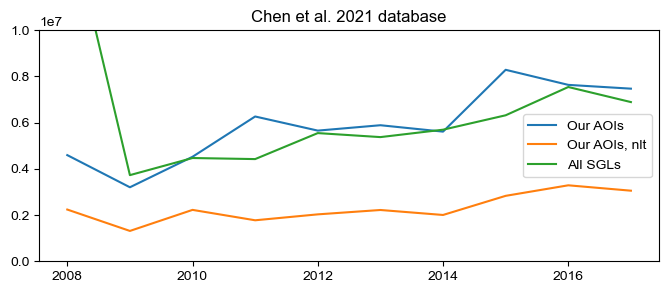

In [11]:
# aggregate total area by year
df_years_c1 = chen_filter[['year', 'Area']].groupby("year").sum(numeric_only=True).reset_index()
df_years_c1_nlt = chen_filter_nlt[['year', 'Area']].groupby("year").sum(numeric_only=True).reset_index()

# plot. 
fig,axs = plt.subplots(figsize=(8,3))
axs.plot(df_years_c1['year'], df_years_c1['Area'], label='Our AOIs')
axs.plot(df_years_c1_nlt['year'], df_years_c1_nlt['Area'], label='Our AOIs, nlt')

# also compare to what is classified in the database as SGLs
chen_all_sgl = chen_all_gdf[chen_all_gdf['Lake_type']=='SGL']
df_years_c2 = chen_all_sgl[['year', 'Area']].groupby("year").sum(numeric_only=True).reset_index()

axs.plot(df_years_c2['year'], df_years_c2['Area'], label='All SGLs')
axs.legend()
axs.set_ylim(0,1e7)
axs.set_title('Chen et al. 2021 database')

### Zhang et al 2023 database

In [12]:
# now lets look at shugar dataset
folder_zhang = os.path.join(folder_datasets, 'lake inventories', 'zhang_2023')

s1 = gpd.read_file(os.path.join(folder_zhang, f'GlacialLake_1990.shp'))
s2 = gpd.read_file(os.path.join(folder_zhang, f'GlacialLake_2000.shp'))
s3 = gpd.read_file(os.path.join(folder_zhang, f'GlacialLake_2010.shp'))
s4 = gpd.read_file(os.path.join(folder_zhang, f'GlacialLake_2015.shp'))
s5 = gpd.read_file(os.path.join(folder_zhang, f'GlacialLake_2020.shp'))

s1['year']=1990
s2['year']=2000
s3['year']=2010
s4['year']=2015
s5['year']=2020

# mosaic into single gdf
zhang_all_gdf = gpd.GeoDataFrame(pd.concat([s1,s2,s3,s4,s5])).to_crs("ESRI:102025")


In [13]:
# filter to include only geometries that intersect with our aois
print(len(zhang_all_gdf))
zhang_filter = zhang_all_gdf.sjoin(dc_gdf[['geometry','rgi_id']]).copy()
print(len(zhang_filter))

# for each polygon in chen_filter, clip to debris_cover extent
c=0
new_geoms = []
new_areas = []
for idx, row in zhang_filter.iterrows():
    c+=1
    # if c>1: continue
    
    # grab this lake's geometry
    g = row['geometry']
    
    # get the debris cover that intersects it
    dc_intersect = dc_gdf[dc_gdf['geometry'].intersects(g)]
    
    # clip lake to this glacier extent
    new_g = shapely.intersection(g, shapely.union_all(dc_intersect['geometry']))
    
    # format new row to save
    new_geoms.append(new_g)
    new_areas.append(new_g.area)

zhang_filter['geometry']=new_geoms
zhang_filter['Area']=new_areas

39879
1285


In [14]:
# subset to only glaciers that are not lake terminating
zhang_filter_nlt = zhang_filter[['year','Area','geometry']].sjoin(dc_gdf_nlt[['geometry','rgi_id']]).copy()
print(len(zhang_filter),len(zhang_filter_nlt))

1285 1175


Text(0.5, 1.0, 'Zhang et al. 2023 database')

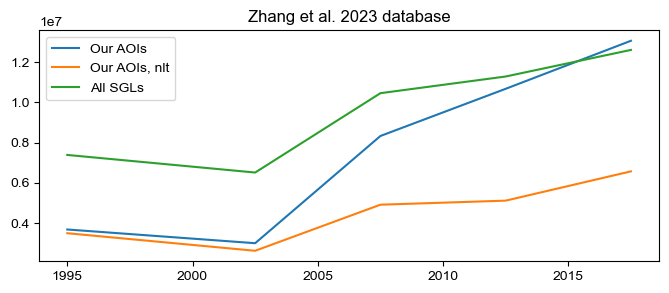

In [15]:
# aggregate total area by year and plot
df_years_z = zhang_filter[['year', 'Area']].groupby("year").sum(numeric_only=True).reset_index()
df_years_z_nlt = zhang_filter_nlt[['year', 'Area']].groupby("year").sum(numeric_only=True).reset_index()
df_years_z['Year_Middle'] = [ 1995, 2002.5, 2007.5, 2012.5, 2017.5 ]
df_years_z_nlt['Year_Middle'] = [ 1995, 2002.5, 2007.5, 2012.5, 2017.5 ]

fig,axs = plt.subplots(figsize=(8,3))
axs.plot(df_years_z['Year_Middle'], df_years_z['Area'], label='Our AOIs')
axs.plot(df_years_z_nlt['Year_Middle'], df_years_z_nlt['Area'], label='Our AOIs, nlt')

# also compare to what is classified in the database as SGLs
zhang_all_sgl = zhang_all_gdf[zhang_all_gdf['Type']=='Supraglacial lakes']
df_years_z2 = zhang_all_sgl[['year', 'Area']].groupby("year").sum(numeric_only=True).reset_index()
df_years_z2['Year_Middle'] = [ 1995, 2002.5, 2007.5, 2012.5, 2017.5 ]
axs.plot(df_years_z2['Year_Middle'], df_years_z2['Area']*1000*1000, label='All SGLs')

axs.legend()
# axs.set_ylim(0,1e7)
axs.set_title('Zhang et al. 2023 database')

### Shugar et al 2020 database

In [16]:
# now lets look at shugar dataset
folder_shugar = os.path.join(folder_datasets, 'lake inventories', 'shugar_2020')

s1 = gpd.read_file(os.path.join(folder_shugar, f'HMA_15_18.shp'))
s2 = gpd.read_file(os.path.join(folder_shugar, f'HMA_10_14.shp'))
s3 = gpd.read_file(os.path.join(folder_shugar, f'HMA_05_09.shp'))
s4 = gpd.read_file(os.path.join(folder_shugar, f'HMA_00_04.shp'))
s5 = gpd.read_file(os.path.join(folder_shugar, f'HMA_90_99.shp'))

# mosaic into single gdf
shugar_all_gdf = gpd.GeoDataFrame(pd.concat([s1,s2,s3,s4,s5])).to_crs("ESRI:102025")


In [17]:
# filter to include only geometries that intersect with our aois
print(len(shugar_all_gdf))
shugar_filter = shugar_all_gdf.sjoin(dc_gdf[['geometry','rgi_id']]).copy()
print(len(shugar_filter))

# for each polygon in chen_filter, clip to debris_cover extent
c=0
new_geoms = []
new_areas = []
for idx, row in shugar_filter.iterrows():
    c+=1
    # if c>1: continue
    
    # grab this lake's geometry
    g = row['geometry']
    
    # get the debris cover that intersects it
    dc_intersect = dc_gdf[dc_gdf['geometry'].intersects(g)]
    
    # clip lake to this glacier extent
    new_g = shapely.intersection(g, shapely.union_all(dc_intersect['geometry']))
    
    # format new row to save
    new_geoms.append(new_g)
    new_areas.append(new_g.area)

shugar_filter['geometry']=new_geoms
shugar_filter['Area']=new_areas

9865
172


In [18]:
# subset to only glaciers that are not lake terminating
shugar_filter_nlt = shugar_filter[['Year_Start','Area','geometry']].sjoin(dc_gdf_nlt[['geometry','rgi_id']]).copy()
print(len(shugar_filter),len(shugar_filter_nlt))

172 92


Text(0.5, 1.0, 'Shugar et al. 2020 database')

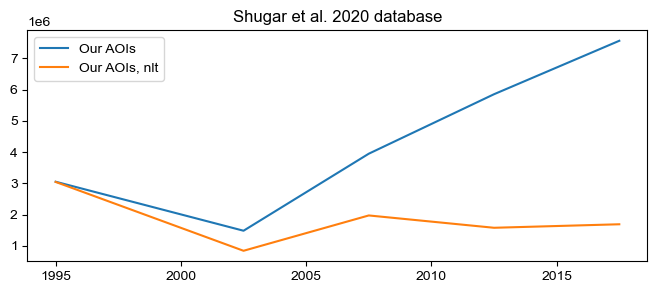

In [19]:
# aggregate total area by year and plot
df_years_s = shugar_filter[['Year_Start', 'Area']].groupby("Year_Start").sum(numeric_only=True).reset_index()
df_years_s['Year_Start'] = [ int(i) for i in df_years_s['Year_Start']]
df_years_s['Year_Middle'] = [ 1995, 2002.5, 2007.5, 2012.5, 2017.5 ]
df_years_s_nlt = shugar_filter_nlt[['Year_Start', 'Area']].groupby("Year_Start").sum(numeric_only=True).reset_index()
df_years_s_nlt['Year_Start'] = [ int(i) for i in df_years_s['Year_Start']]
df_years_s_nlt['Year_Middle'] = [ 1995, 2002.5, 2007.5, 2012.5, 2017.5 ]


fig,axs = plt.subplots(figsize=(8,3))
axs.plot(df_years_s['Year_Middle'], df_years_s['Area'], label='Our AOIs')
axs.plot(df_years_s_nlt['Year_Middle'], df_years_s_nlt['Area'], label='Our AOIs, nlt')

axs.legend()
# axs.set_ylim(0,1e7)
axs.set_title('Shugar et al. 2020 database')

### Wang et al 2020 database

In [20]:
# now lets look at wang dataset
folder_wang = os.path.join(folder_datasets, 'lake inventories', 'wang_2020')

w1 = gpd.read_file(os.path.join(folder_wang, f'High_Asia_glacial_lake_1990.shp'))
w2 = gpd.read_file(os.path.join(folder_wang, f'High_Asia_glacial_lake_2018.shp'))
w1['year']=1990
w2['year']=2018

# mosaic into single gdf
wang_all_gdf = gpd.GeoDataFrame(pd.concat([w1,w2])).to_crs("ESRI:102025")

In [21]:
# filter to include only geometries that intersect with our aois
print(len(wang_all_gdf))
wang_filter = wang_all_gdf.sjoin(dc_gdf[['geometry','rgi_id']]).copy()
print(len(wang_filter))

# for each polygon in chen_filter, clip to debris_cover extent
c=0
new_geoms = []
new_areas = []
for idx, row in wang_filter.iterrows():
    c+=1
    # if c>1: continue
    
    # grab this lake's geometry
    g = row['geometry']
    
    # get the debris cover that intersects it
    dc_intersect = dc_gdf[dc_gdf['geometry'].intersects(g)]
    
    # clip lake to this glacier extent
    new_g = shapely.intersection(g, shapely.union_all(dc_intersect['geometry']))
    
    # format new row to save
    new_geoms.append(new_g)
    new_areas.append(new_g.area)

wang_filter['geometry']=new_geoms
wang_filter['Area']=new_areas

55042
517


In [22]:
# subset to only glaciers that are not lake terminating
wang_filter_nlt = wang_filter[['year','Area','geometry']].sjoin(dc_gdf_nlt[['geometry','rgi_id']]).copy()
print(len(wang_filter),len(wang_filter_nlt))

517 489


Text(0.5, 1.0, 'Wang et al. 2020 database')

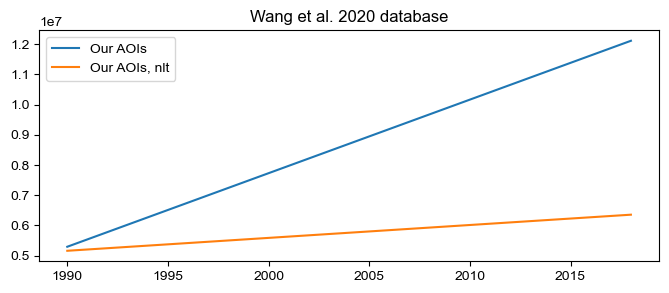

In [23]:
# aggregate total area by year and plot
df_years_w = wang_filter[['year', 'Area']].groupby("year").sum(numeric_only=True).reset_index()
df_years_w_nlt = wang_filter_nlt[['year', 'Area']].groupby("year").sum(numeric_only=True).reset_index()

fig,axs = plt.subplots(figsize=(8,3))
axs.plot(df_years_w['year'], df_years_w['Area'], label='Our AOIs')
axs.plot(df_years_w_nlt['year'], df_years_w_nlt['Area'], label='Our AOIs, nlt')

axs.legend()
axs.set_title('Wang et al. 2020 database')

### Racoviteanu et al 2021 database

In [24]:
# now lets look at wang dataset
folder_rac = os.path.join(folder_datasets, 'lake inventories', 'racoviteanu_2021', 'shapefiles')

rac_all_gdf = gpd.read_file(os.path.join(folder_rac, f'Himalaya_L8_unmix_6cl_water_binary.shp')).to_crs("ESRI:102025")
rac_all_gdf['year']=2015

In [25]:
# filter to include only geometries that intersect with our aois
print(len(rac_all_gdf))
rac_filter = rac_all_gdf.sjoin(dc_gdf[['geometry','rgi_id']]).copy()
print(len(rac_filter))

# for each polygon in chen_filter, clip to debris_cover extent
c=0
new_geoms = []
new_areas = []
for idx, row in rac_filter.iterrows():
    c+=1
    # if c>1: continue
    
    # grab this lake's geometry
    g = row['geometry']
    
    # get the debris cover that intersects it
    dc_intersect = dc_gdf[dc_gdf['geometry'].intersects(g)]
    
    # clip lake to this glacier extent
    new_g = shapely.intersection(g, shapely.union_all(dc_intersect['geometry']))
    
    # format new row to save
    new_geoms.append(new_g)
    new_areas.append(new_g.area)

rac_filter['geometry']=new_geoms
rac_filter['Area']=new_areas

# subset to only glaciers that are not lake terminating
rac_filter_nlt = rac_filter[['Area','geometry']].sjoin(dc_gdf_nlt[['geometry','rgi_id']]).copy()
print(len(rac_filter),len(rac_filter_nlt))


rac_area = np.nansum(rac_filter['Area'])
rac_area_nlt = np.nansum(rac_filter_nlt['Area'])
print("Total area:", rac_area/(1000*1000))
print("Total area, nlt:", rac_area_nlt/(1000*1000))

20874
6392
6392 6162
Total area: 14.31029607435256
Total area, nlt: 13.849338166153833


### Comparison of them all

In [77]:
# open quick snapshot of our data to compare against
our_path = os.path.join(folder_datasets, 'total_lake_area_annual_binned4.csv')
our_df = pd.read_csv(our_path)

our_path = os.path.join(folder_datasets, 'total_lake_area_annual_rac_binned4.csv')
our_df_rac = pd.read_csv(our_path)

our_path = os.path.join(folder_datasets, 'total_lake_area_annual_zhang_binned4.csv')
our_df_z = pd.read_csv(our_path)

our_df_z.head(2)

,year,area_nlt_km2,area_all_km2
0,1989.5,7.3557,7.7076
1,1992.5,5.2974,5.4972


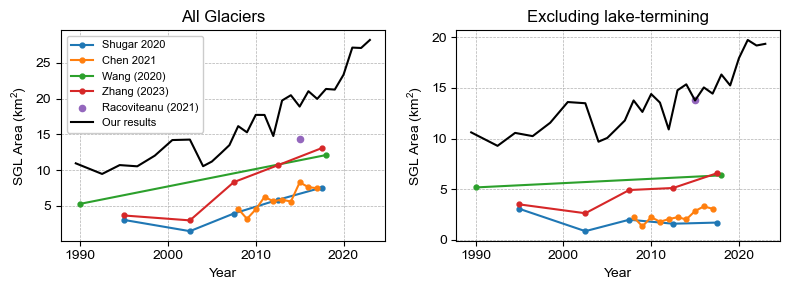

In [78]:
# plot total lake area in km2
fig,axs = plt.subplots(1,2, figsize=(8,3), sharey=False)

# define how to normalize
norm_value = 1000*1000 # turn m2 to km2
# norm_value = total_dc_area/100 # turn m2 to % glacier coverage

# define scatter marker size
msize = 7

# all, including lake terminating
axs[0].plot(df_years_s['Year_Middle'], df_years_s['Area']/norm_value, label='Shugar 2020',
            zorder=5, markersize=msize, marker='.')
axs[0].plot(df_years_c1['year'], df_years_c1['Area']/norm_value, label='Chen 2021',
            zorder=5, markersize=msize, marker='.')
axs[0].plot(df_years_w['year'], df_years_w['Area']/norm_value, label='Wang (2020)',
            zorder=5, markersize=msize, marker='.')
axs[0].plot(df_years_z['Year_Middle'], df_years_z['Area']/norm_value, label='Zhang (2023)',
            zorder=5, markersize=msize, marker='.')
axs[0].scatter([2015],rac_area/norm_value, label = "Racoviteanu (2021)", zorder=5, s=20, c='tab:purple')
  

# excluding lake terminating
axs[1].plot(df_years_s_nlt['Year_Middle'], df_years_s_nlt['Area']/norm_value, label='Shugar (2020)',
            zorder=5, markersize=msize, marker='.')
axs[1].plot(df_years_c1_nlt['year'], df_years_c1_nlt['Area']/norm_value, label='Chen (2021)',
            zorder=5, markersize=msize, marker='.')
axs[1].plot(df_years_w_nlt['year'], df_years_w_nlt['Area']/norm_value, label='Wang (2020)',
            zorder=5, markersize=msize, marker='.')
axs[1].plot(df_years_z_nlt['Year_Middle'], df_years_z_nlt['Area']/norm_value, label='Zhang (2023)',
            zorder=5, markersize=msize, marker='.')
axs[1].scatter([2015],rac_area_nlt/norm_value, label = "Racoviteanu (2021)", zorder=5, s=20, c='tab:purple')

# put our results on top at the end
axs[0].plot(our_df['year'], our_df['area_all_km2'], label='Our results', c='black',
            zorder=5)
axs[1].plot(our_df['year'], our_df['area_nlt_km2'], label='Our results', c='black',
            zorder=5)

axs[0].grid(zorder=1, linestyle='dashed', linewidth=0.5)
axs[0].set_xlabel("Year")
axs[0].set_ylabel("SGL Area (km$^2$)")
axs[0].set_title("All Glaciers")

# axs[1].legend(loc='center left', bbox_to_anchor=(1,0.5))
axs[0].legend(framealpha=1, fontsize=8)
axs[1].grid(zorder=1, linestyle='dashed', linewidth=0.5)
axs[1].set_xlabel("Year")
axs[1].set_ylabel("SGL Area (km$^2$)")
axs[1].set_title("Excluding lake-termining")

plt.tight_layout(w_pad=1.5)

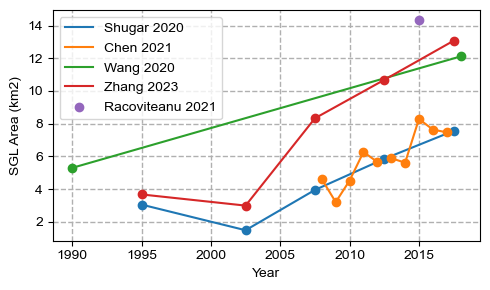

In [79]:
# plot total lake area in km2
fig,axs = plt.subplots(figsize=(5,3))

# define how to normalize
norm_value = 1000*1000 # turn m2 to km2
# norm_value = total_dc_area/100 # turn m2 to % glacier coverage

axs.plot(df_years_s['Year_Middle'], df_years_s['Area']/norm_value, label='Shugar 2020',zorder=5)
axs.plot(df_years_c1['year'], df_years_c1['Area']/norm_value, label='Chen 2021',zorder=5)
axs.plot(df_years_w['year'], df_years_w['Area']/norm_value, label='Wang 2020',zorder=5)
axs.plot(df_years_z['Year_Middle'], df_years_z['Area']/norm_value, label='Zhang 2023',zorder=5)

axs.scatter(df_years_s['Year_Middle'], df_years_s['Area']/norm_value, zorder=5)
axs.scatter(df_years_c1['year'], df_years_c1['Area']/norm_value, zorder=5)
axs.scatter(df_years_w['year'], df_years_w['Area']/norm_value, zorder=5)
axs.scatter(df_years_z['Year_Middle'], df_years_z['Area']/norm_value, zorder=5)

axs.scatter([2015],rac_area/norm_value, label = "Racoviteanu 2021",zorder=5)
    
axs.legend()
axs.grid(linewidth=1, linestyle='dashed',zorder=1)

axs.set_xlabel("Year")
axs.set_ylabel("SGL Area (km2)")
plt.tight_layout()

Text(0, 0.5, 'SGL Area (km2)')

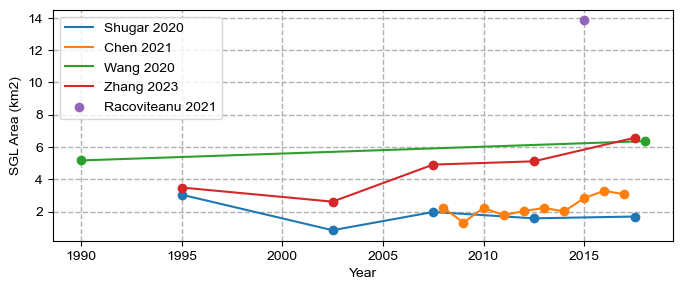

In [80]:
# only non lake terminating glaciers
dc_area_m2 = total_dc_area

# plot total lake area in m2
fig,axs = plt.subplots(figsize=(8,3))

axs.plot(df_years_s_nlt['Year_Middle'], df_years_s_nlt['Area']/norm_value, label='Shugar 2020',zorder=5)
axs.plot(df_years_c1_nlt['year'], df_years_c1_nlt['Area']/norm_value, label='Chen 2021',zorder=5)
axs.plot(df_years_w_nlt['year'], df_years_w_nlt['Area']/norm_value, label='Wang 2020',zorder=5)
axs.plot(df_years_z_nlt['Year_Middle'], df_years_z_nlt['Area']/norm_value, label='Zhang 2023',zorder=5)

axs.scatter(df_years_s_nlt['Year_Middle'], df_years_s_nlt['Area']/norm_value, zorder=5)
axs.scatter(df_years_c1_nlt['year'], df_years_c1_nlt['Area']/norm_value, zorder=5)
axs.scatter(df_years_w_nlt['year'], df_years_w_nlt['Area']/norm_value, zorder=5)
axs.scatter(df_years_z_nlt['Year_Middle'], df_years_z_nlt['Area']/norm_value, zorder=5)

axs.scatter([2015],rac_area_nlt/norm_value, label = "Racoviteanu 2021",zorder=5)
    
axs.legend()
axs.grid(linewidth=1, linestyle='dashed',zorder=1)

axs.set_xlabel("Year")
axs.set_ylabel("SGL Area (km2)")

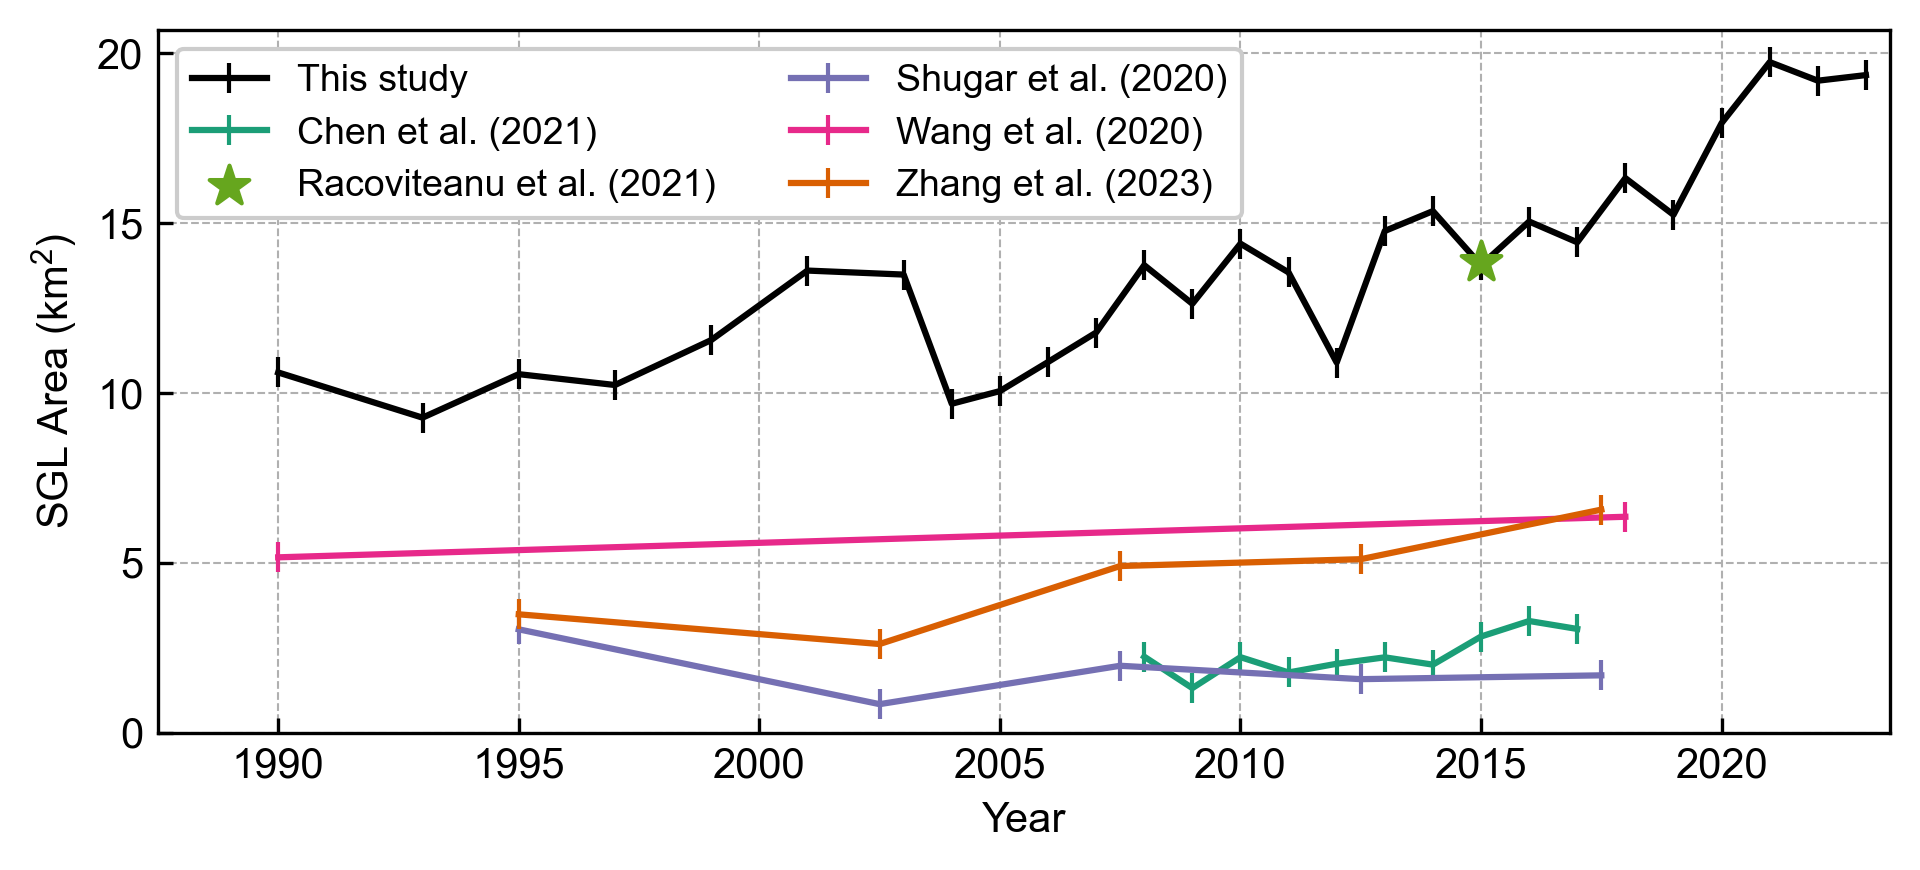

In [81]:
# publication-ready figure
fig,ax = plt.subplots(figsize=(6.5,3), dpi=300)

# define how to normalize
norm_value = 1000*1000 # turn m2 to km2

# define colors
cs = plt.cm.Dark2(np.linspace(0, 1, 8))
# cs = plt.cm.Set1(np.linspace(0, 1, 9))

# define scatter marker size
msize = 7

# plot our timeseries
our_years = our_df['year'].values
our_years = [ y if y>=2004 else y+0.5 for y in our_years ]
ax.plot(our_years, our_df['area_nlt_km2'], label='This study',
        zorder=5, markersize=msize, marker='|', c='black')

# other datasets
ax.plot(df_years_c1_nlt['year'], df_years_c1_nlt['Area']/norm_value, label='Chen et al. (2021)',
            zorder=5, markersize=msize, marker='|', c=cs[0])

ax.scatter([2015],rac_area_nlt/norm_value, label = "Racoviteanu et al. (2021)",
           zorder=5, s=100, color=cs[4], marker="*", edgecolor=None)

ax.plot(df_years_s_nlt['Year_Middle'], df_years_s_nlt['Area']/norm_value, label='Shugar et al. (2020)',
            zorder=5, markersize=msize, marker='|', c=cs[2])

ax.plot(df_years_w_nlt['year'], df_years_w_nlt['Area']/norm_value, label='Wang et al. (2020)',
            zorder=5, markersize=msize, marker='|', c=cs[3])

ax.plot(df_years_z_nlt['Year_Middle'], df_years_z_nlt['Area']/norm_value, label='Zhang et al. (2023)',
            zorder=5, markersize=msize, marker='|', c=cs[1])

ax.set_xlabel("Year")
ax.set_ylabel("SGL Area (km$^2$)")
ax.set_ylim(0,)
ax.set_xlim(1987.5,2023.5)
ax.set_facecolor("white")

ax.tick_params(axis="both",direction="in")
ax.grid(zorder=1, linestyle='dashed', linewidth=0.5)

ax.legend(framealpha=1, fontsize=9, ncols=2)

plt.tight_layout()

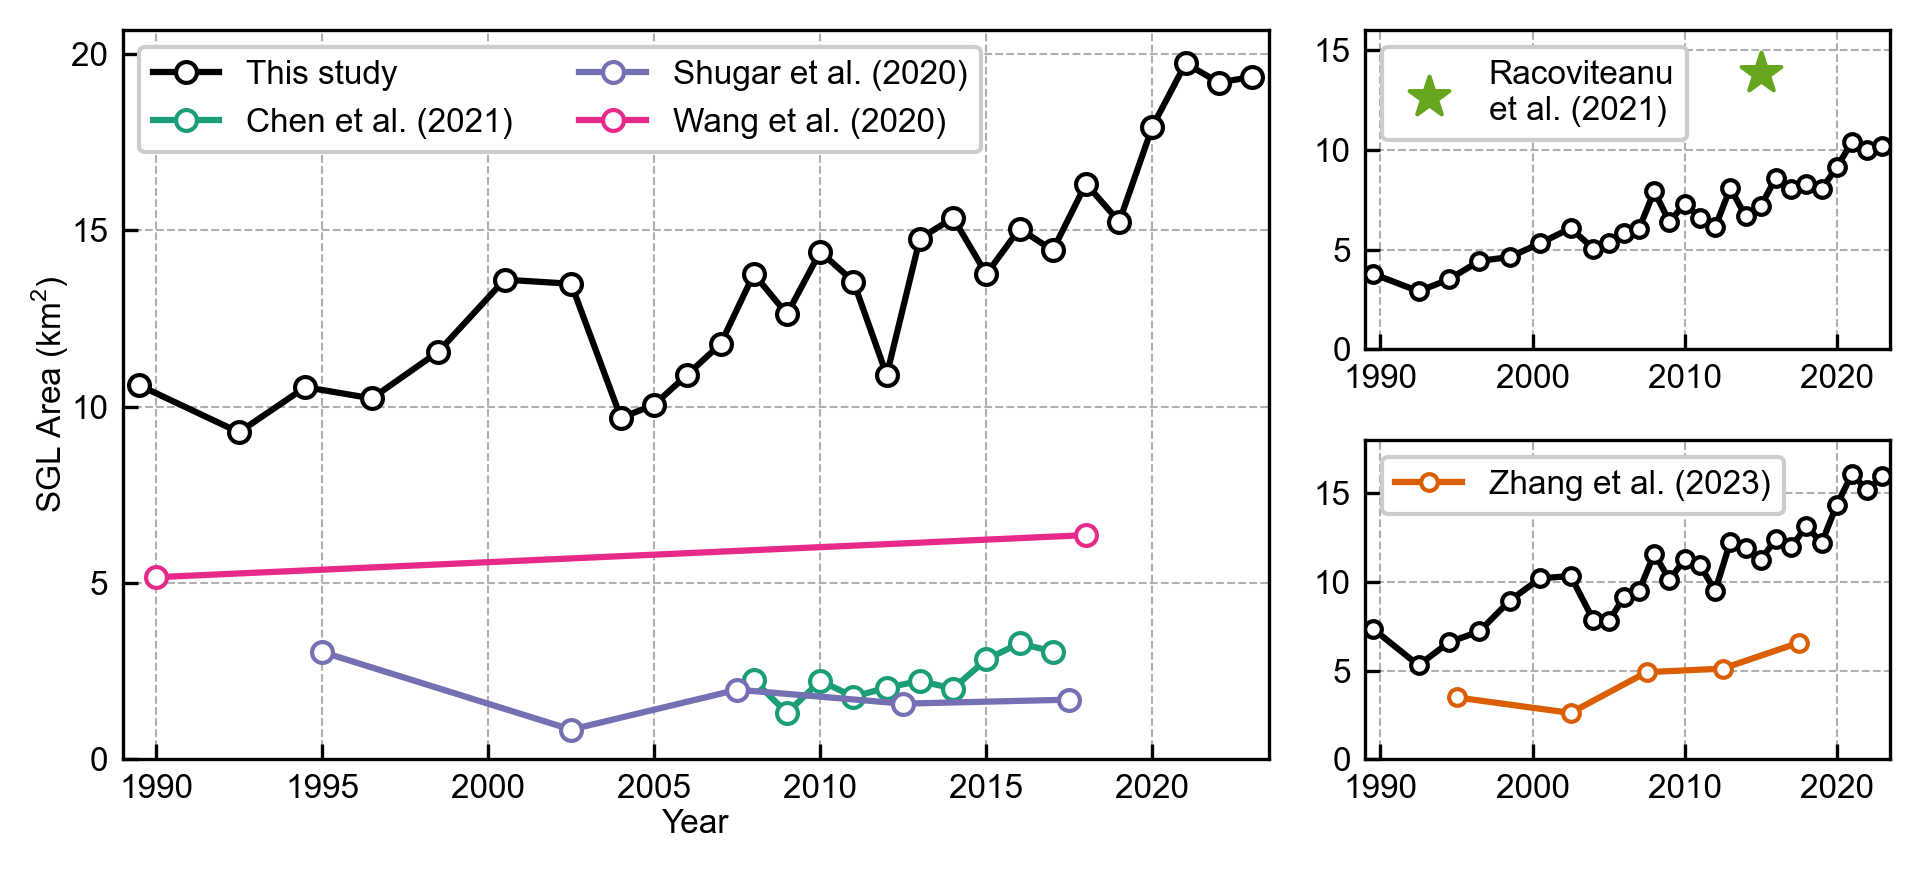

In [82]:
# publication-ready figure 2. separate zhang and racoviteanu
# fig,ax = plt.subplots(figsize=(6.5,3), dpi=300)
fig = plt.figure(figsize=(6.5,3), dpi=300)
gs = fig.add_gridspec(2,3)
ax1 = fig.add_subplot(gs[:, :2])
ax2 = fig.add_subplot(gs[0, -1])
ax3 = fig.add_subplot(gs[1, -1])
axs = (ax1,ax2,ax3)

# define how to normalize
norm_value = 1000*1000 # turn m2 to km2

# define colors
cs = plt.cm.Dark2(np.linspace(0, 1, 8))
# cs = plt.cm.Set1(np.linspace(0, 1, 9))

# define scatter marker size
msize = 5


### ax1, main comparison
our_years = our_df['year'].values
ax1.plot(our_years, our_df['area_nlt_km2'], label='This study',
        zorder=5, c='black', markersize=msize, marker='o', markerfacecolor="white",
            markeredgecolor='black', markeredgewidth=1, )

ax1.plot(df_years_c1_nlt['year'], df_years_c1_nlt['Area']/norm_value, label='Chen et al. (2021)',
            zorder=5, c=cs[0], markersize=msize, marker='o', markerfacecolor="white",
            markeredgecolor=cs[0], markeredgewidth=1, )

ax1.plot(df_years_s_nlt['Year_Middle'], df_years_s_nlt['Area']/norm_value, label='Shugar et al. (2020)',
            zorder=5, c=cs[2], markersize=msize, marker='o', markerfacecolor="white",
            markeredgecolor=cs[2], markeredgewidth=1, )

ax1.plot(df_years_w_nlt['year'], df_years_w_nlt['Area']/norm_value, label='Wang et al. (2020)',
            zorder=5, c=cs[3], markersize=msize, marker='o', markerfacecolor="white",
            markeredgecolor=cs[3], markeredgewidth=1, )


### ax2, racoviteanu
ax2.plot(our_years, our_df_rac['area_nlt_km2'], zorder=5, c='black', markersize=msize-1,
         marker='o', markerfacecolor="white", markeredgecolor='black', markeredgewidth=1, )

ax2.scatter([2015],rac_area_nlt/norm_value, label = "Racoviteanu\net al. (2021)",
           zorder=5, s=100, color=cs[4], marker="*", edgecolor=None)


### ax3, zhang
ax3.plot(our_years, our_df_z['area_nlt_km2'], zorder=5, c='black', markersize=msize-1,
         marker='o', markerfacecolor="white", markeredgecolor='black', markeredgewidth=1, )

ax3.plot(df_years_z_nlt['Year_Middle'], df_years_z_nlt['Area']/norm_value, label='Zhang et al. (2023)',
            zorder=5, c=cs[1], markersize=msize-1, marker='o', markerfacecolor="white",
            markeredgecolor=cs[1], markeredgewidth=1, )

for ax in axs:
    ax.set_ylim(0,)
    ax.set_xlim(1989,2023.5)
    ax.set_facecolor("white")

    ax.tick_params(axis="both",direction="in")
    ax.grid(zorder=1, linestyle='dashed', linewidth=0.5)
    ax.tick_params(axis='both', labelsize=8)

ax1.legend(framealpha=1, fontsize=8, ncols=2)
ax2.legend(framealpha=1, fontsize=8, ncols=2, loc='upper left')
ax3.legend(framealpha=1, fontsize=8, ncols=2)

ax1.set_yticks([0,5,10,15,20])
ax2.set_ylim(0,16)
ax3.set_ylim(0,18)
    
ax1.set_xlabel("Year", fontsize=8, labelpad=1)
ax1.set_ylabel("SGL Area (km$^2$)", fontsize=8, labelpad=0)

plt.tight_layout()

save = 1
if save:
    plt.savefig(os.path.join(folder_HMA,'Figures','inventory comparison',f'comparison.png'),
                transparent=False, bbox_inches='tight', dpi=300)

In [83]:
# print stats on how much the multi-step inventories underestimate
print("Shugar 1990s",(df_years_s_nlt['Area'].values[0]/norm_value) / (our_df[our_df['year']<=2000]['area_nlt_km2'].mean()))
print("Shugar 2000",(df_years_s_nlt['Area'].values[1]/norm_value) / (our_df[(our_df['year']>=2000)&(our_df['year']<=2005)]['area_nlt_km2'].mean()))
print("Shugar 2020",(df_years_s_nlt['Area'].values[-1]/norm_value) / (our_df[(our_df['year']>=2015)&(our_df['year']<=2018)]['area_nlt_km2'].mean()))

Shugar 1990s 0.29140175899183623
Shugar 2000 0.07187686829839346
Shugar 2020 0.11345755166326388


In [84]:
# print stats on how much the multi-step inventories underestimate
print("Racoviteanu",(rac_area_nlt/norm_value) / (our_df_rac[ our_df_rac['year'].isin([2014,2015,2106])]['area_nlt_km2'].mean()))

Racoviteanu 2.000149934093547


In [85]:
df_years_s_nlt

,Year_Start,Area,Year_Middle
0,1990,3.043965e+06,1995.0
1,2000,8.415254e+05,2002.5
2,2005,1.972055e+06,2007.5
3,2010,1.577529e+06,2012.5
4,2015,1.689746e+06,2017.5
